In [1]:
import numpy as np

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel, sem

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    
    return onehot.cumsum(axis=time_axis)


def log_utility(counts):
    return np.log(counts[:, 1:] + 1).sum(axis=1)


def linear_utility(counts):
    return counts[:, 1:].sum(axis=1)


data = 'morgan'

# group_size = 1
# num_exps = 120
# num_repeats_per_exp = 5

group_size = 5
num_exps = 20
num_repeats_per_exp = 1

policies = [
    'ens jensen greedy',
    # 'classical ens',
    'greedy',
    'round robin greedy',
]
if group_size == 1 and 'round robin greedy' in policies:
    policies.remove('round robin greedy')
    
utility_function = log_utility

n_classes = group_size + 1
init_size = 1
budget = 500

basepath = os.path.join('../../data/results/backup/results 1101 - 1011', data)


utilities = np.ones(
    (len(policies), num_exps, num_repeats_per_exp, budget + init_size)
) * -1

for p_ind, policy in enumerate(policies):
    for exp_ind in range(num_exps):
        path = os.path.join(basepath, f'{data}{exp_ind + 1}', str(group_size), policy)
        for i in range(num_repeats_per_exp):
            labels = np.loadtxt(
                os.path.join(path, f'{policy}__labels__{i + 1}.csv'), 
                dtype=int
            ).flatten() - 1

            utilities[p_ind, exp_ind, i, :] = log_utility(labels_to_counts(labels))
        
assert np.all(utilities != -1)

In [3]:
utilities.shape

(3, 20, 1, 501)

In [4]:
utilities[..., -1].mean(axis=(1, 2))

array([10.79128505, 10.87167379, 10.98620386])

ens jensen greedy: 18.5924
greedy: 19.0880
round robin greedy: 19.1494


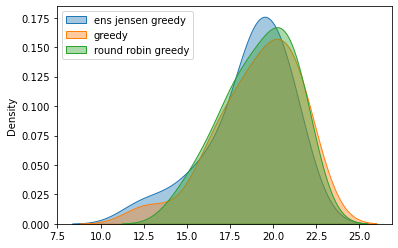

In [6]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, ..., -1].mean():.4f}')
    sns.kdeplot(utilities[p_ind, ..., -1].flatten(), alpha=0.4, shade=True, label=policy)
    
plt.legend(loc='upper left');

In [7]:
print(utilities.shape)
utilities

(3, 20, 1, 505)


array([[[[ 0.69314718,  1.38629436,  2.07944154, ..., 18.66941068,
          18.68058398, 18.69163382]],

        [[ 0.69314718,  1.38629436,  2.07944154, ..., 19.05388075,
          19.11103916, 19.11103916]],

        [[ 0.69314718,  1.38629436,  2.07944154, ..., 19.85103409,
          19.86812853, 19.88493565]],

        ...,

        [[ 0.69314718,  1.38629436,  2.07944154, ..., 14.26816455,
          14.26816455, 14.26816455]],

        [[ 0.69314718,  1.38629436,  2.07944154, ..., 15.59481681,
          15.59481681, 16.00028191]],

        [[ 0.69314718,  1.38629436,  2.07944154, ..., 19.27328466,
          19.29270275, 19.31175094]]],


       [[[ 0.69314718,  1.38629436,  2.07944154, ..., 17.4556461 ,
          17.46762229, 17.46762229]],

        [[ 0.69314718,  1.38629436,  2.07944154, ..., 19.72564357,
          19.7355939 , 19.74544619]],

        [[ 0.69314718,  1.38629436,  2.07944154, ..., 19.85083815,
          19.85083815, 19.85083815]],

        ...,

        [[ 0.693

In [8]:
squeezed_utilities =  utilities.reshape(
    len(policies), 
    num_exps * num_repeats_per_exp, 
    budget + init_size
)

print(squeezed_utilities.shape)
squeezed_utilities

(3, 20, 505)


array([[[ 0.69314718,  1.38629436,  2.07944154, ..., 18.66941068,
         18.68058398, 18.69163382],
        [ 0.69314718,  1.38629436,  2.07944154, ..., 19.05388075,
         19.11103916, 19.11103916],
        [ 0.69314718,  1.38629436,  2.07944154, ..., 19.85103409,
         19.86812853, 19.88493565],
        ...,
        [ 0.69314718,  1.38629436,  2.07944154, ..., 14.26816455,
         14.26816455, 14.26816455],
        [ 0.69314718,  1.38629436,  2.07944154, ..., 15.59481681,
         15.59481681, 16.00028191],
        [ 0.69314718,  1.38629436,  2.07944154, ..., 19.27328466,
         19.29270275, 19.31175094]],

       [[ 0.69314718,  1.38629436,  2.07944154, ..., 17.4556461 ,
         17.46762229, 17.46762229],
        [ 0.69314718,  1.38629436,  2.07944154, ..., 19.72564357,
         19.7355939 , 19.74544619],
        [ 0.69314718,  1.38629436,  2.07944154, ..., 19.85083815,
         19.85083815, 19.85083815],
        ...,
        [ 0.69314718,  1.38629436,  2.07944154, ..., 1

In [9]:
for p1 in range(len(policies) - 1):
    for p2 in range(p1 + 1, len(policies)):
        if squeezed_utilities[p1, :, -1].mean() < squeezed_utilities[p2, :, -1].mean():
            alternative = "less"
        else:
            alternative = "greater"
        
        print(policies[p1], "vs.", policies[p2])
        print(
            ttest_rel(
                squeezed_utilities[p1, :, -1], 
                squeezed_utilities[p2, :, -1],
                alternative=alternative
            ).pvalue
        )
    print()

ens jensen greedy vs. greedy
0.0016033241369711785
ens jensen greedy vs. round robin greedy
0.011232169323594896

greedy vs. round robin greedy
0.32518526031346723



17.468713545566224 19.716081385810128
0.5618
17.969770887674052 20.20623295573988
0.5591
18.179786996522022 20.119064662274422
0.4848


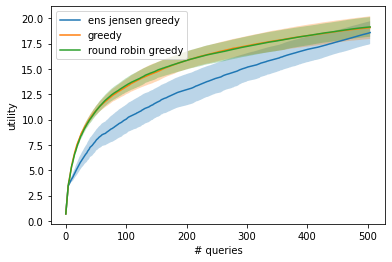

In [10]:
plt.figure()

for p_ind, policy in enumerate(policies):
    plt.plot(squeezed_utilities[p_ind].mean(axis=0), label=policy)
    lower, upper = DescrStatsW(squeezed_utilities[p_ind]).tconfint_mean()
    plt.fill_between(np.arange(init_size + budget), lower, upper, alpha=0.3)
    
    print(lower[-1], upper[-1])
    print(f'{(upper[-1] - lower[-1]) / 4:.4f}')
    
plt.xlabel("# queries")
plt.ylabel("utility")
plt.legend();